# Quick start
Показываю, как пользоваться моделькой

# Preparation

In [1]:
from model import VanillaArch

import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from torchvision.transforms import functional as TF
import cv2
import pyiqa
import scipy
import os, shutil
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
model = VanillaArch(
    saliency_mode="none",
    fusion="none",
    gradcam_mode="none",
    calculate_gradcam_in_eval_mode=False
)

model.eval().cuda()
print()

Модель возвращает объекти типа `dataclass` такой структуры:
```python
@dataclass
class VanillaOutput:
    pred_score: Tensor
    gradcam: Optional[Tensor] = None
    pred_saliency: Optional[Tensor] = None
```
Нужное нам поле называется `pred_score`. Сделаем модель-обертку, которая будет возвращать только предсказанное качество изображения

In [4]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def forward(self, image):
        pred = self.model(image)
        return pred.pred_score
    
    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path)['params'])
    
wrapped_model = WrappedModel(model)

Есть 4 чекпоинта:
* `weights_baseline.pth` - обычная модель
* `weights_gradcam.pth` - gradcam модели похож на салиенси
* `weights_corners.pth` - модель смотрит в углы
* `weights_vg_hard.pth` - модель смотрит по паттерну *vg*
* `weights_vg_soft.pth` - модель смотрит по паттерну *vg*. В середине обучения лосс по gradcam меньшен в 1000 раз


Загрузим последний:

In [57]:
! cp '../../experiments/023-GradCam-stock/0_2023-11-29_14:00:29/models/net_best.pth' weights_baseline.pth
! cp '../../experiments/021-AntiGradCam-1e-3-minus/1_2023-11-28_20:55:27/models/net_best.pth' weights_corners.pth
! cp '../../experiments/023-GradCam-VG_alpha=1e-3_loss=NormL1/3_2023-11-29_00:22:58/models/net_best.pth' weights_gradcam.pth
! cp '../../experiments/023-GradCam-VG-L_alpha=1e-1_loss=NormL1_hflip=false/0_2023-11-29_00:46:02/models/net_best.pth' weights_vg_hard.pth
! cp '../../experiments/023-GradCam-VG-L_alpha=1e-2_loss=NormL1_hflip=false_finetuning=1e-5-log-gradnorms/0_2023-11-29_19:35:11/models/net_best.pth' weights_vg_soft.pth

In [58]:
all_weights = [
    'weights_baseline.pth',
    'weights_gradcam.pth',
    'weights_corners.pth',
    'weights_vg_hard.pth',
    'weights_vg_soft.pth'
]
wrapped_model.load_weights(all_weights[-1])

# Demo
Рандомная картинки из интернетов

In [59]:
! wget https://tokmo.su/wp-content/uploads/2023/07/i.jpg -O cat.jpg

--2023-12-02 01:27:29--  https://tokmo.su/wp-content/uploads/2023/07/i.jpg
Resolving tokmo.su (tokmo.su)... 217.107.34.187
Connecting to tokmo.su (tokmo.su)|217.107.34.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119488 (117K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 116,69K  --.-KB/s    in 0,008s  

2023-12-02 01:27:29 (14,9 MB/s) - ‘cat.jpg’ saved [119488/119488]



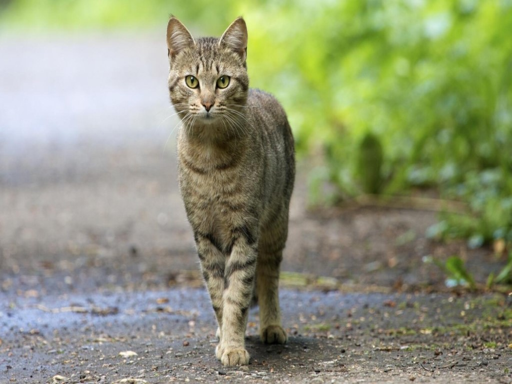

In [60]:
image = Image.open('cat.jpg')
image = image.resize((512, 384))
image

In [61]:
image = torch.tensor(np.array(image).astype('float') / 255).float()

Т.к. датасет я тебе не передам (он весит гигабайт), то просто буду зашумлять картинку. Ожидается, что модель сможет оценить интенсивность шума

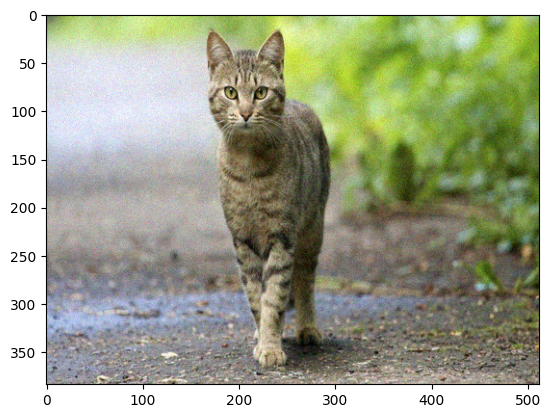

In [62]:
def corrupt_image(image, intensity):
    noise = torch.randn(*image.shape) * intensity / 255
    image = (image + noise).clip(0, 1)
    return image

plt.imshow(corrupt_image(image, 10))

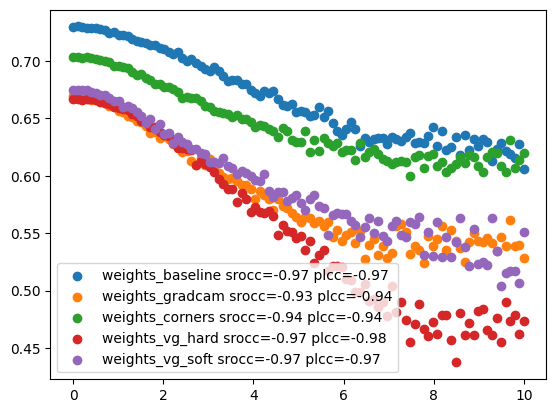

In [63]:
for weights in all_weights:
    wrapped_model.load_weights(weights)
    intensity_space = np.linspace(0, 10, 100)
    pred_scores = []
    for intensity in intensity_space:
        corrupted_image = corrupt_image(image, intensity).permute(2, 0, 1).unsqueeze(0).cuda()
        with torch.no_grad():
            pred_score = wrapped_model(corrupted_image)
            pred_score = pred_score.item()
        pred_scores.append(pred_score)

    srocc = scipy.stats.spearmanr(intensity_space, pred_scores)[0]
    plcc = scipy.stats.pearsonr(intensity_space, pred_scores)[0]

    plt.scatter(intensity_space, pred_scores, label=f'{weights.replace(".pth", "")} {srocc=:.2f} {plcc=:.2f}')
plt.legend()
plt.show()

Все четко

# GradCam

In [64]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [65]:
def build_gradcam(model, image, *, target_layers, gradcam_cls=GradCAM):
    input_tensor = image.unsqueeze(0).cuda()
    cam = gradcam_cls(model=model, target_layers=target_layers, use_cuda=True)
    targets = [RawScoresOutputTarget()]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    return grayscale_cam

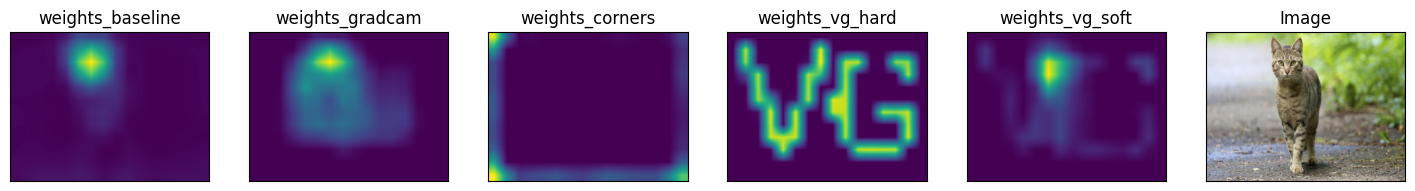

<Figure size 640x480 with 0 Axes>

In [66]:
def make_comparison_of_images(image):
    image_tensor = image.permute(2, 0, 1)
    method = GradCAM

    n_rows = 1
    n_columns = 1 + len(all_weights)
    ax_shape = (3, 2.5)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(ax_shape[0] * n_columns, ax_shape[1] * n_rows))

    for j, weights in zip(range(len(all_weights)), all_weights):
        wrapped_model.load_weights(weights)
        grayscale_cam = build_gradcam(wrapped_model, image_tensor, target_layers=[model.backbone[-1]], gradcam_cls=method)
        axs[j].imshow(grayscale_cam)
        axs[j].set_title(weights.replace('.pth', ''))
        axs[j].set_xticks([])
        axs[j].set_yticks([])

    axs[-1].imshow(image.numpy())
    axs[-1].set_title('Image')
    axs[-1].set_xticks([])
    axs[-1].set_yticks([])

    plt.show()      
    plt.suptitle('Comparison of different gradcams')
    plt.tight_layout()

make_comparison_of_images(image)